In [1]:
import sys
import numpy as np
import tensorflow as tf
from models import ConcreteDropout, KerasMCDropout
from keras.models import Sequential
import keras.backend as K
from keras import initializers, regularizers
from keras.engine import InputSpec
from keras.layers import Dense, Lambda, Wrapper, Dropout
np.random.seed(0)

Using TensorFlow backend.


# Set some global parameters

In [2]:
K_test = 100
batch_size = 20
n_hidden = [512,512,512]
l = 1e-4
hi_percentile = 97.5
low_percentile = 2.5
default_dropout_rate = 0.5

# Synthetic Data Generator

In [3]:
def gen_signal(X):
    return np.sin(2*X)

def gen_data(N, sigma=0.1):
    X = np.random.randn(N,1)*2
    noise = sigma*np.random.randn(N, 1)
    Y = gen_signal(X) + noise
    return X, Y

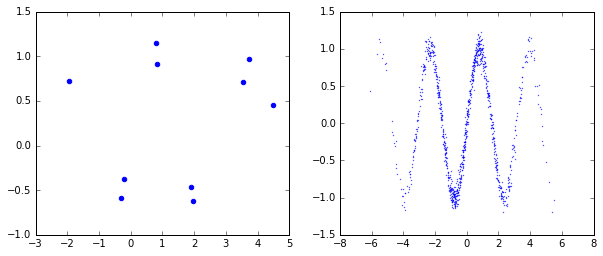

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

X, Y = gen_data(10)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(X[:, 0], Y[:, 0], edgecolor='b')

X, Y = gen_data(1000)
plt.subplot(1,2,2)
plt.scatter(X[:, 0], Y[:, 0], edgecolor='b', s=0.1)
plt.show()

# Fit Concrete Dropout

In [5]:
from keras.layers import Input, Dense, Lambda, merge
from keras.models import Model
from keras import backend as K

def fit_model(nb_epoch, X, Y, output_activation=None, verbose=0):
    if K.backend() == 'tensorflow':
        K.clear_session()
    N = X.shape[0]
    wd = l**2. / N
    dd = 2. / N
    inp = Input(shape=(X.shape[1],))
    x = inp
    for h in n_hidden:
        x = ConcreteDropout(Dense(h, activation='relu'), weight_regularizer=wd, 
                            dropout_regularizer=dd)(x)
    mean = ConcreteDropout(Dense(1, activation=output_activation), 
                           weight_regularizer=wd, dropout_regularizer=dd)(x)
    log_var = ConcreteDropout(Dense(1), weight_regularizer=wd, dropout_regularizer=dd)(x)
    out = merge([mean, log_var], mode='concat')
    model = Model(inp, out)
    def heteroscedastic_loss(true, pred):
        mean = pred[:, :1]
        log_var = pred[:, 1:]
        precision = K.exp(-log_var)
        return K.sum(precision * (true - mean)**2. + log_var, -1)
    
    model.compile(optimizer='adam', loss=heteroscedastic_loss)
    hist = model.fit(X, Y, epochs=nb_epoch, batch_size=batch_size, verbose=verbose)
    loss = hist.history['loss']
    return model, loss  # return ELBO up to const.

In [7]:
X_train, Y_train = gen_data(100, 1.)
model, _ = fit_model(100, X_train, Y_train, verbose=0)

/Users/tj/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:19: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


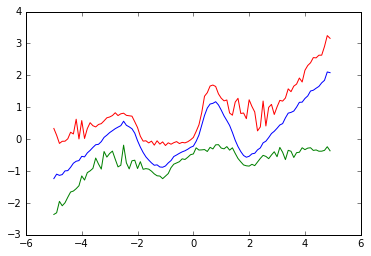

In [8]:
X_test = np.arange(-5,5,0.1)
Y_test = gen_signal(X_test)
Y_samples = np.array([model.predict(X_test[:,np.newaxis])[:,0] for _ in range(K_test)])
Y_pred = Y_samples.mean(axis=0)
Y_low = np.percentile(Y_samples, 0.5, axis=0)
Y_high = np.percentile(Y_samples, 99.5, axis=0)
plt.plot(X_test, Y_pred)
plt.plot(X_test, Y_low)
plt.plot(X_test, Y_high)


# MC-Dropout

In [9]:
def fit_mc(nb_epoch, X, Y, output_activation=None, verbose=0,
           alpha_divergence=True, alpha=0.5, dropout_prob=0.5):
    if K.backend() == 'tensorflow':
        K.clear_session()
    N = X.shape[0]
    D = np.prod(X.shape[1:])
    inp = Input(shape=X.shape[1:])
    x = inp
    #default_dropout_rate = 0.1
    for h in n_hidden:
        x = KerasMCDropout(Dense(h, activation='relu'), dropout_prob=dropout_prob)(x)
        
    mean = KerasMCDropout(Dense(1, activation=output_activation), dropout_prob=dropout_prob)(x)
    log_var = KerasMCDropout(Dense(1), dropout_prob=default_dropout_rate)(x)
    out = merge([mean, log_var], mode='concat')
    model = Model(inp, out)
    
    def alpha_divergence_loss(true, pred):
        # heteroskedastic case
        mean = pred[:,:1]
        log_var = pred[:,1:]
        precision = K.exp(-log_var)
        ll = K.sum(precision * (true - mean)**2. + log_var, axis=0)
        l = -1/alpha*K.log(K.sum(K.exp(-alpha*ll)))

        # homoskedastic case
        #l = -1/alpha*K.log(K.sum(K.exp(-alpha*tau/2.*K.sum((true - mean)**2, axis=0))))
        #l += N * D / 2. * K.log(tau)
        return l
       # return K.sum(precision * (true - pred)**2. + log_var, -1)
    
    def heteroskedastic_loss(true, pred):
        mean = pred[:,:1]
        log_var = pred[:,1:]
        precision = K.exp(-log_var)
        return K.sum(precision * (true - mean)**2. + log_var)
        
    if alpha_divergence:
        model.compile(optimizer='adam', loss=alpha_divergence_loss)
    else:
        model.compile(optimizer='adam', loss=heteroskedastic_loss)
        
    hist = model.fit(X, Y, epochs=nb_epoch, batch_size=batch_size, verbose=verbose)
    loss = hist.history['loss']
    return model, loss  # return ELBO up to const.


In [12]:
X_train, Y_train = gen_data(100, 1.)
X_test = np.arange(-7.5,7.5,0.1)
Y_test = gen_signal(X_test)


mc_model, _ = fit_mc(1000, X_train, Y_train, verbose=0, 
                     alpha_divergence=False, dropout_prob=0.50)

/Users/tj/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


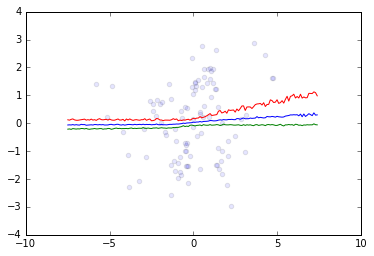

In [14]:
Y_samples = np.array([mc_model.predict(X_test) for _ in range(K_test)])
Y_mean = np.mean(Y_samples[:,:,0], axis=0)

sample_mean = np.mean(Y_samples[:,:,0], axis=0)
yhi  = np.percentile(Y_samples[:,:,0], hi_percentile,  axis=0)
ylow = np.percentile(Y_samples[:,:,0], low_percentile, axis=0)

plt.plot(X_test, sample_mean)
plt.plot(X_test, ylow)
plt.plot(X_test, yhi)
plt.scatter(X_train, Y_train, alpha=0.2)
plt.show()

## Dropout with Alpha-Divergence Loss

### General Loss function
$\mathcal{L}(\Theta) = \dfrac{1}{\alpha} \sum_n \text{log-sum-exp}\big[ -\alpha * l(y_n, f^{\hat{\omega}_k}(x_n)) \big] + L_2(\Theta)$

### Regression Loss
$l(y, f^{\hat{\omega}_k}(x_n)) = \dfrac{1}{2}||y - f^{\hat{\omega}_k}(x)||_2^2$

### Regression Alpha-Divergence Loss
$\mathcal{L}(\Theta) = -\dfrac{1}{\alpha} \sum_n \text{log-sum-exp} \big[ -\dfrac{\alpha\tau}{2}||y - f^{\hat{\omega}_k}(x)||_2^2 \big] + \dfrac{ND}{2}\text{log}\tau + \sum_i p_i ||M_i||_2^2$

In [86]:

X_train, Y_train = gen_data(10, 0.01)
X_test = np.arange(-8,8,0.1) # 50
Y_test = gen_signal(X_test)

alpha_model, _ = fit_mc(1000, X_train, Y_train, verbose=0, alpha_divergence=False, 
                        dropout_prob=0.25)
#mc_model, _ = fit_mc(1000, X_train, Y_train, verbose=0, alpha_divergence=True)


/Users/tj/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:59: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


[-0.03528862 -0.01374061  0.03960026  0.07706372 -0.01848457 -0.04468308
  0.0509216  -0.03350502 -0.01086483  0.01538197]
[-1.30065455 -1.36580434 -1.14779432 -1.19432867 -1.37647228 -1.21163445
 -1.19113186 -1.15424324 -1.1836877  -1.2331899 ]


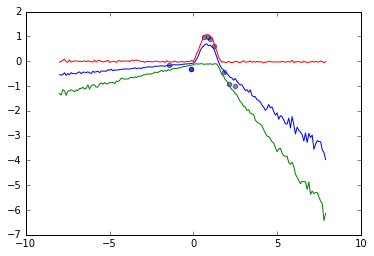

In [87]:
Y_samples = np.array([alpha_model.predict(X_test) for _ in range(K_test)])
Y_mean = np.mean(Y_samples[:,:,0], axis=0)
second_moment = np.zeros(Y_samples.shape[1])
for k in range(K_test):
    sample_var = np.exp(Y_samples[k,:,1])
    sample_mean = Y_samples[k,:,0]
    second_moment += sample_var + sample_mean**2
Y_var = second_moment / K_test #- Y_mean**2

sample_mean = np.mean(Y_samples[:,:,0], axis=0)
yhi  = np.percentile(Y_samples[:,:,0], hi_percentile,  axis=0)
ylow = np.percentile(Y_samples[:,:,0], low_percentile, axis=0)
#yhi = sample_mean + np.std(Y_var)
#hlow = sample_mean - np.std(Y_var)
print yhi[:10]
print ylow[:10]
plt.plot(X_test, sample_mean)
plt.plot(X_test, ylow)
plt.plot(X_test, yhi)
plt.scatter(X_train, Y_train, alpha=0.5)

# Climate Downscaling Experiments

## Read Data

In [1]:
import pandas as pd

def read_file(f):
    data = pd.read_csv(f, header=None)
    data = data.rename(columns={0: 'time', 1: 'label'})
    for c in data.columns:
        if isinstance(c, int) and ((c % 2) == 1):
            del data[c]
    X = data.values[:,2:]
    X = X.reshape((X.shape[0], 9, 9))[:,:,:,np.newaxis]
    plt.imshow(X[0,:,:,0], interpolation='nearest')
    plt.show()
    y = data.values[:,1,np.newaxis]
    return X, y

train_file = 'data/train_28.5384_-81.3792'
test_file = 'data/test_28.5384_-81.3792'

X_train, Y_train = read_file(train_file)
X_test, Y_test = read_file(test_file)
print X_train.shape, Y_train.shape

NameError: global name 'np' is not defined

## Fit Concrete Dropout

In [2]:
from keras.layers import Conv2D, MaxPooling2D, Flatten
from sklearn.preprocessing import StandardScaler 

def fit_concrete_climate(nb_epoch, X, Y, output_activation=None, verbose=0):

    if K.backend() == 'tensorflow':
        K.clear_session()
    N = X.shape[0]
    wd = l**2. / N
    dd = 2. / N
    inp = Input(shape=X.shape[1:])
    x = inp
    for h in n_hidden:
        x = ConcreteDropout(Conv2D(h, (3,3), padding='valid', activation='relu'), 
                            weight_regularizer=wd, 
                            dropout_regularizer=dd)(x)
    #x = K.reshape(x, (-1, 9*9))
    x = Flatten()(x)
    mean = ConcreteDropout(Dense(1, activation=output_activation), 
                           weight_regularizer=wd, dropout_regularizer=dd)(x)
    log_var = ConcreteDropout(Dense(1), weight_regularizer=wd, dropout_regularizer=dd)(x)
    out = merge([mean, log_var], mode='concat')
    model = Model(inp, out)
    def heteroscedastic_loss(true, pred):
        mean = pred[:, :1]
        log_var = pred[:, 1:]
        precision = K.exp(-log_var)
        return K.sum(precision * (true - mean)**2. + log_var, -1)
    model.compile(optimizer='adam', loss=heteroscedastic_loss)
    hist = model.fit(X, Y, epochs=nb_epoch, batch_size=batch_size, verbose=verbose)
    loss = hist.history['loss']
    return model, loss  # return ELBO up to const.

Using TensorFlow backend.


In [3]:
x_mu = np.mean(X_train)
x_std = np.std(X_train)
X_train_norm = (X_train - x_mu) / x_std
X_test_norm = (X_test - x_mu) / x_std

scale_y = StandardScaler().fit(Y_train)
Y_train_norm = scale_y.transform(Y_train)

K.clear_session()
model, loss = fit_concrete_climate(5, X_train_norm, Y_train_norm, output_activation='relu', 
                        verbose=1)
Y_samples = np.array([model.predict(X_test)[:,0] for _ in range(K_test)])
Y_samples = scale_y.inverse_transform(Y_samples)
Y_pred = Y_samples.mean(axis=0)

NameError: name 'np' is not defined

In [ ]:
model.predict(X_train)
loss

In [ ]:
import seaborn as sns

lw=0.1
idxs = np.argsort(Y_test[:,0])

for idx in idxs[::-1][:10]:
    sns.kdeplot(Y_samples[:,idx], shade=True)
    plt.vlines(Y_test[idx,0], 0, 1, color='red', alpha=0.5)
    plt.vlines(Y_pred[idx], 0, 1, color='blue', alpha=0.5)
    plt.show()